<a href="https://colab.research.google.com/github/gaurangm-web/ML-examples/blob/main/ML_classif_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook illustrates some standard ML methods (with scikit-learn and pandas) on publicly available datasets



**Import required python modules:**

In [181]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MaxAbsScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Load data 



Here, cardiotocogram data for fetal heart health (from https://archive.ics.uci.edu/ml/datasets/cardiotocography) from a csv file as a pandas dataframe. The file is loaded from local drive folder, but could also be directly downloaded from the web.

In [23]:
data = pd.read_csv('/content/drive/My Drive/Downloaded_Datasets/fetal_health.csv',sep=',')

View dataframe:

In [90]:
print(data.shape)
data.head()

(2126, 22)


,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


There are 21 independent numerical variables and last column corresponds to health status (3 possible classes: 1 (normal), 2 (suspect), 3 (disease)).

Preparing array of independent variables (X) and class labels (y vector):

In [81]:
X_dropped_cols = ['fetal_health']
y_colname = 'fetal_health'

X = data.drop(columns=X_dropped_cols)
y = data[y_colname]   

## No. of unique class labels:
classes = list(y.unique())

print(X.shape,y.shape)
print('Classes:',classes)

(2126, 21) (2126,)
Classes: [2.0, 1.0, 3.0]


**Dividing the full dataset into learning ("training + tuning/validation") and a held-out test ("reporting") sets**

The train/test examples are stratified to have same frequency distribution over the different classes

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

## Checking relative frequencies of classes among train/test sets:
print('Train #:',len(y_train))
for c in classes: print(c,len(y_train[y_train == c]))

print('Test #:',len(y_test))
for c in classes: print(c,len(y_test[y_test == c]))

Train #: 1700
2.0 236
1.0 1323
3.0 141
Test #: 426
2.0 59
1.0 332
3.0 35



## Implementing a random forest classifier


m = sqrt(num_parameters) random features chosen per split, and 100 decision trees (bootstrap sampling of training set).

Class weights are adjusted according to their relative proportions in the training set. 

In [69]:
rfc = RandomForestClassifier(n_estimators=100,class_weight='balanced',
                             max_depth=None,criterion='gini',oob_score=False,max_features='auto',random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Classification accuracy on test set and F1-score (averaged as well as per-class; F-score may be more relevant when dataset is imbalanced):

In [70]:
y_pred = rfc.predict(X_test)
acc = rfc.score(X_test,y_test)
f1_perclass = f1_score(y_test,y_pred,average=None,labels=y_train.unique())
f1_avg = f1_score(y_test,y_pred,average='weighted')

print('Clf accuracy:',acc, '\nMean F1-score:',f1_avg)
for c,f1 in sorted(zip(classes,f1_perclass),key=lambda f: f[0]): print(c,f1) 

Class. Accuracy: 0.9342723004694836 
Mean F1-score: 0.9306473075936014
1.0 0.963181148748159
2.0 0.9142857142857143
3.0 0.7572815533980584


Importance of individual features for classification



- Based on sorting features according to their individual contribution to reduction in gini impurity across splits

In [36]:
for f,imp in sorted(zip(data.columns,list(rfc.feature_importances_)),key = lambda fi: fi[1], reverse=True): print(f, imp)

abnormal_short_term_variability 0.13619111581885324
percentage_of_time_with_abnormal_long_term_variability 0.13589881997927505
histogram_mean 0.09176986562233648
histogram_median 0.07271809376742816
mean_value_of_short_term_variability 0.06711153596848017
accelerations 0.06637624478895474
histogram_mode 0.06089189342804046
prolongued_decelerations 0.05750860706516698
mean_value_of_long_term_variability 0.05632112947042861
histogram_variance 0.04482206933243308
baseline value 0.04196103864506142
histogram_width 0.03572288797974654
uterine_contractions 0.024304612564376566
histogram_max 0.023991599990584485
histogram_min 0.023808009098936468
fetal_movement 0.020440643691942248
histogram_number_of_peaks 0.015280907972859123
light_decelerations 0.011274011851583103
histogram_tendency 0.00966645994212078
histogram_number_of_zeroes 0.00317454861188001
severe_decelerations 0.000765904409512275


- Based on permutation testing on training data (means and std deviations)

In [37]:
perm_imp = permutation_importance(rfc, X_train, y_train, n_repeats=10, random_state=0)
for f,imp_mu,imp_sd in sorted(zip(data.columns,list(perm_imp.importances_mean),list(perm_imp.importances_std)),key = lambda fi: fi[1], reverse=True): print(f, imp_mu, imp_sd)

abnormal_short_term_variability 0.07858823529411763 0.0042189226063626085
percentage_of_time_with_abnormal_long_term_variability 0.049588235294117634 0.0030115119379224044
accelerations 0.04570588235294115 0.003893477821970093
mean_value_of_short_term_variability 0.0361176470588235 0.002188361792675081
histogram_mean 0.015117647058823503 0.0017656860023298451
histogram_median 0.009352941176470564 0.0016098743745181204
histogram_mode 0.008999999999999975 0.001765686002329859
prolongued_decelerations 0.007294117647058796 0.00039019115180648076
mean_value_of_long_term_variability 0.004941176470588204 0.0014456712620523093
baseline value 0.004117647058823526 0.0007440653318043062
histogram_variance 0.0033529411764705807 0.0010205500925233944
fetal_movement 0.0028823529411764583 0.00041176470588236705
uterine_contractions 0.0024117647058823468 0.001273906342806348
histogram_width 0.0015882352941176126 0.0006470588235293996
histogram_number_of_peaks 0.001470588235294068 0.0003946002313234809

Performance of RF classifier as a functon of number of trees:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


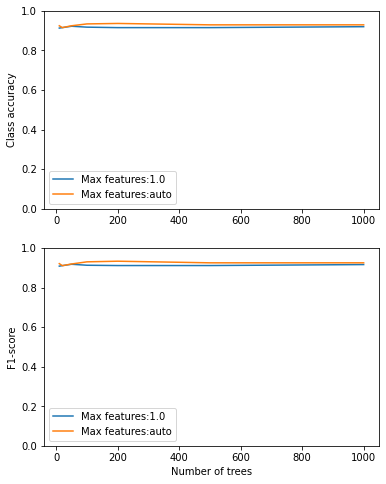

In [46]:
## Max_features: number of features to use at every split; default is "auto" (sqrt(n_features)), 
## which is compared to considering all features at every split (max_features = 1.0)

fig, ax = plt.subplots(figsize=(6, 8))

n_trees = [10,20,50,100,200,500,1000]

for max_f in [1.0,"auto"]:

  cls,f1 = [],[] 
  for n_est in n_trees:

    #print(n_est)
    rfc = RandomForestClassifier(n_estimators=n_est,class_weight="balanced",
                              max_depth=None,criterion='gini',oob_score=False,max_features=max_f,random_state=42)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    cls.append(rfc.score(X_test,y_test))
    f1.append(f1_score(y_test,y_pred,average='weighted'))

  plt.subplot(2,1,1)
  plt.plot(n_trees,cls,'-',label='Max features:'+str(max_f))
  plt.ylim([0,1])
  plt.ylabel('Classif. accuracy')
  plt.legend(loc='best')
  
  plt.subplot(2,1,2)
  plt.plot(n_trees,f1,'-',label='Max features:'+str(max_f))
  plt.ylim([0,1])
  plt.ylabel('F1-score')
  plt.legend(loc='best')

  plt.xlabel('Number of trees')


## Applying boosting (AdaBoost classifier)

Default setting of base_estimator is decision tree classifier with max_depth=1 (stumps)

Learning rate and n_estimators (# trees) are tunable parameters

In [47]:
abc = AdaBoostClassifier(base_estimator=None, n_estimators=100, learning_rate=.1, random_state=42)
abc.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=100, random_state=42)

Classification accuracy on test set and F1-score (averaged as well as per-class; F-score may be more relevant when dataset is imbalanced):

In [48]:
y_pred = abc.predict(X_test)
acc = abc.score(X_test,y_test)
f1_perclass = f1_score(y_test,y_pred,average=None,labels=y_train.unique())
f1_avg = f1_score(y_test,y_pred,average='weighted')

print('Clf accuracy:',acc, '\nMean F1-score:',f1_avg)
for c,f1 in sorted(zip(y_train.unique(),f1_perclass),key=lambda f: f[0]): print(c,f1)

Class. Accuracy: 0.8802816901408451 
Mean F1-score: 0.8674478242001026
1.0 0.9285714285714285
2.0 0.7058823529411764
3.0 0.5599999999999999


Feature-wise importance for classification:

In [50]:
for f,imp in sorted(zip(data.columns,list(abc.feature_importances_)),key = lambda fi: fi[1], reverse=True): print(f, imp)

abnormal_short_term_variability 0.26
histogram_mean 0.13
accelerations 0.09
prolongued_decelerations 0.09
histogram_mode 0.09
percentage_of_time_with_abnormal_long_term_variability 0.08
histogram_variance 0.07
mean_value_of_short_term_variability 0.06
fetal_movement 0.05
baseline value 0.03
uterine_contractions 0.02
histogram_min 0.02
mean_value_of_long_term_variability 0.01
light_decelerations 0.0
severe_decelerations 0.0
histogram_width 0.0
histogram_max 0.0
histogram_number_of_peaks 0.0
histogram_number_of_zeroes 0.0
histogram_median 0.0
histogram_tendency 0.0


Importance of individual features based on permutation testing

In [51]:
perm_imp = permutation_importance(abc, X_train, y_train, n_repeats=10, random_state=0)
for f,imp_mu,imp_sd in sorted(zip(data.columns,list(perm_imp.importances_mean),list(perm_imp.importances_std)),key = lambda fi: fi[1], reverse=True): print(f, imp_mu, imp_sd)

accelerations 0.043882352941176525 0.004692628394159787
mean_value_of_short_term_variability 0.042411764705882406 0.004342196596226028
abnormal_short_term_variability 0.0355882352941177 0.003580512422007795
histogram_mode 0.026294117647058877 0.0012352941176470597
histogram_mean 0.025411764705882422 0.004031021576238078
percentage_of_time_with_abnormal_long_term_variability 0.022058823529411832 0.0036852835547475497
prolongued_decelerations 0.019294117647058906 0.0007803823036130251
mean_value_of_long_term_variability 0.008411764705882396 0.002004320592635399
histogram_variance 0.005941176470588306 0.0014276071881778253
uterine_contractions 0.002647058823529469 0.0016481089089555084
baseline value 0.001235294117647101 0.0005549400665915839
light_decelerations 0.0 0.0
severe_decelerations 0.0 0.0
histogram_width 0.0 0.0
histogram_max 0.0 0.0
histogram_number_of_peaks 0.0 0.0
histogram_number_of_zeroes 0.0 0.0
histogram_median 0.0 0.0
histogram_tendency 0.0 0.0
histogram_min -0.000823529

## Multi-layer perceptron (MLP) classification

Scaling feature values by the max absolute value per feature 

The scaler could be changed to StandardScaler() or other normalization types as needed.

In [53]:
## Scaling is applied to the training data, and the same scaler will be used on the test data before predictions, to avoid data leakage)
scaler = MaxAbsScaler().fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
X_train_scaled.head()#,y_train.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
0,0.83125,0.000000,0.000000,0.857143,0.066667,0.0,0.4,0.697674,0.428571,0.000000,0.000000,0.551136,0.364780,0.651261,0.222222,0.0,0.668449,0.527473,0.564516,0.311024,0.0
1,0.91250,0.333333,0.000000,0.214286,0.000000,0.0,0.0,0.441860,0.142857,0.000000,0.215686,0.278409,0.792453,0.735294,0.166667,0.0,0.802139,0.835165,0.822581,0.019685,0.0
2,0.80625,0.000000,0.002096,0.500000,0.400000,0.0,0.4,0.779070,0.457143,0.000000,0.000000,0.454545,0.415094,0.613445,0.388889,0.0,0.561497,0.439560,0.575269,0.035433,0.0
3,0.83750,0.444444,0.002096,0.714286,0.400000,0.0,0.0,0.709302,0.157143,0.000000,0.090686,0.619318,0.503145,0.794118,0.555556,0.0,0.834225,0.791209,0.811828,0.240157,0.0
4,0.78125,0.000000,0.010482,0.071429,0.066667,0.0,0.0,0.813953,0.057143,0.318681,0.174020,0.460227,0.327044,0.558824,0.277778,0.0,0.668449,0.675824,0.672043,0.007874,1.0


Applying fully-connected neural net classifier with two 100-unit hidden layers to the scaled training data; alpha is a regularization parameter which may be tuned to mitigate overfitting:

In [74]:
mlpc = MLPClassifier(hidden_layer_sizes=(100,100),random_state=42, max_iter=1000,solver="adam",alpha=0.1)
mlpc.fit(X_train_scaled, y_train)

MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Performance on held-out test set (max of softmax class probabilities per test sample):

In [76]:
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

y_pred = mlpc.predict(X_test_scaled)
acc = mlpc.score(X_test_scaled,y_test)
f1_perclass = f1_score(y_test,y_pred,average=None,labels=y_train.unique())
f1_avg = f1_score(y_test,y_pred,average='weighted')

print('Clf accuracy:',acc, '\nMean F1-score:',f1_avg)
for c,f1 in sorted(zip(y_train.unique(),f1_perclass),key=lambda f: f[0]): print(c,f1)

Class. Accuracy: 0.8873239436619719 
Mean F1-score: 0.8899420061932886
1.0 0.937784522003035
2.0 0.6666666666666667
3.0 0.8125


## Multi-class logistic regression as a baseline classifier

Standardization of numerial feature values:

In [72]:
## Scaling is applied to the training data, and the same scaler will be used on the test data before predictions, to avoid data leakage)
stdscaler = StandardScaler().fit(X_train)
X_train_stdscaled = stdscaler.transform(X_train)

## Default is L2 regularization; C: inverse of reg. strength (penalty on model complexity/flexibility). 
## Here, C is fixed, but could be potentially optimized via crossvalidation.

lrc = LogisticRegression(C=1.0,random_state=42,max_iter=1000,class_weight='balanced')
lrc.fit(X_train_stdscaled, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Performance on held-out test/reporting set:

In [86]:
## Scaling test instances w.r.t. the training set:
X_test_stdscaled = pd.DataFrame(stdscaler.transform(X_test),columns=X_test.columns)

y_pred = lrc.predict(X_test_stdscaled)
#y_proba = lrc.predict_proba(X_test_stdscaled)
acc = lrc.score(X_test_stdscaled,y_test)
f1_perclass = f1_score(y_test,y_pred,average=None,labels=y_train.unique())
f1_avg = f1_score(y_test,y_pred,average='weighted')

print('Clf accuracy:',acc, '\nMean F1-score:',f1_avg)
for c,f1 in sorted(zip(classes,f1_perclass),key=lambda f: f[0]): print(c,f1)

Class. Accuracy: 0.8568075117370892 
Mean F1-score: 0.869425995427322
1.0 0.9196141479099679
2.0 0.7792207792207793
3.0 0.6405228758169934




---



## Example 2: Brain cancer gene expression dataset


This example works with a public microarray dataset of 130 brain samples (5 cancer types + normal) from the [CuMiDa](https://sbcb.inf.ufrgs.br/cumida) database (GEO accession GSE50161, downloaded via [Kaggle](https://www.kaggle.com/brunogrisci/brain-cancer-gene-expression-cumida)).


---



**Load data, prepare input/label arrays**

In [87]:
gex = pd.read_csv('/content/drive/My Drive/Downloaded_Datasets/Brain_GSE50161.csv')

In [88]:
print(gex.shape)
gex.head()

(130, 54677)


,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,1438_at,1487_at,1494_f_at,1552256_a_at,1552257_a_at,1552258_at,1552261_at,1552263_at,1552264_a_at,1552266_at,1552269_at,1552271_at,1552272_a_at,1552274_at,1552275_s_at,1552276_a_at,1552277_a_at,1552278_a_at,1552279_a_at,1552280_at,1552281_at,1552283_s_at,1552286_at,1552287_s_at,1552288_at,1552289_a_at,1552291_at,1552293_at,...,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMRGE/M10098_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,AFFX-LysX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-M27830_3_at,AFFX-M27830_5_at,AFFX-M27830_M_at,AFFX-PheX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-r2-Bs-dap-3_at,AFFX-r2-Bs-dap-5_at,AFFX-r2-Bs-dap-M_at,AFFX-r2-Bs-lys-3_at,AFFX-r2-Bs-lys-5_at,AFFX-r2-Bs-lys-M_at,AFFX-r2-Bs-phe-3_at,AFFX-r2-Bs-phe-5_at,AFFX-r2-Bs-phe-M_at,AFFX-r2-Bs-thr-3_s_at,AFFX-r2-Bs-thr-5_s_at,AFFX-r2-Bs-thr-M_s_at,AFFX-r2-Ec-bioB-3_at,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,834,ependymoma,12.498150,7.604868,6.880934,9.027128,4.176175,7.224920,6.085942,6.835999,5.898355,5.513410,7.541986,7.905140,7.108117,8.386617,8.412090,6.560058,5.779307,5.596102,9.128874,6.822846,8.222273,5.965720,6.070791,6.522746,7.031419,6.514768,8.333490,6.699891,8.290555,6.330756,7.429331,8.271134,6.889821,6.789864,6.332943,6.743534,7.683195,6.725073,...,7.452986,6.286898,4.769155,4.687528,3.754204,3.896775,4.473275,8.171548,6.060622,8.841900,5.902276,3.907297,3.882678,3.890110,3.668144,3.390117,3.953972,3.529272,3.563981,4.574315,3.828851,4.483687,5.011438,5.773626,4.827817,5.877779,6.714268,6.080413,7.475681,7.086287,9.979005,9.926470,12.719785,12.777792,5.403657,4.870548,4.047380,3.721936,4.516434,4.749940
1,835,ependymoma,13.067436,7.998090,7.209076,9.723322,4.826126,7.539381,6.250962,8.012549,5.453147,6.173106,8.317030,8.269136,7.250662,9.208559,8.466202,5.822008,5.862887,5.573160,8.853524,5.855870,6.914568,6.856960,7.268411,7.805840,7.953560,7.049230,7.985905,8.285225,9.759504,5.638496,7.963333,6.503762,7.413667,8.128855,5.010720,6.483549,7.349033,6.153470,...,9.122687,6.487188,5.011087,5.125493,3.459905,3.475047,4.250283,8.026929,7.974346,9.139429,6.088559,3.955786,3.744942,3.475500,3.545111,3.288044,3.798083,3.465220,3.398081,4.279519,3.365857,3.673009,4.822057,5.048771,4.988880,7.645660,7.913366,7.398476,9.145736,9.137122,11.924749,11.215930,13.605662,13.401342,5.224555,4.895315,3.786437,3.564481,4.430891,4.491416
2,836,ependymoma,13.068179,8.573674,8.647684,9.613002,4.396581,7.813101,6.007746,7.178156,8.400266,6.323471,7.661874,8.327897,7.557231,9.344553,9.161303,6.352456,5.703981,6.296894,8.912298,6.115325,6.706525,7.236168,7.062774,7.702766,7.713712,7.146639,8.958272,5.966615,8.235646,5.393936,8.168913,7.446118,7.032315,7.511554,5.241585,6.878393,7.881382,6.073385,...,9.822739,6.453939,4.549771,4.578991,3.512840,3.480678,4.457866,8.097331,7.070830,9.434220,6.109699,4.096394,3.813011,3.387800,3.579731,3.307294,3.639748,3.256938,3.377463,4.280787,3.434739,3.541582,4.877465,5.268649,5.395714,7.933271,8.191778,7.930424,9.689873,9.609895,12.154405,11.532460,13.764593,13.477800,5.303565,5.052184,4.005343,3.595382,4.563494,4.668827
3,837,ependymoma,12.456040,9.098977,6.628784,8.517677,4.154847,8.361843,6.596064,6.347285,4.900380,6.008684,7.663790,7.730238,6.890946,8.996408,7.967699,5.565398,5.656941,7.255397,7.725901,5.835465,8.985858,6.688773,6.582501,7.073578,7.603237,6.420513,9.477679,5.921865,7.775342,4.808373,7.077664,8.321482,7.732976,9.187663,4.644900,6.021278,8.720681,6.124541,...,8.028984,11.005884,12.747103,11.065442,3.516075,3.584663,4.171380,7.079637,12.800238,10.747585,6.509987,4.243607,3.820466,3.584356,3.917221,3.455213,3.802537,3.803922,3.467714,4.268587,3.380387,3.593411,4.956109,4.774260,4.626221,8.613308,8.654348,8.623225,9.9

Listing all classes in the dataset:

In [93]:
## 'type': Column listing labels/classes
classes = list(gex.type.unique())
for c,n in Counter(gex.type).items(): print(c,n)

ependymoma 46
glioblastoma 34
medulloblastoma 22
normal 13
pilocytic_astrocytoma 15


Making a numerical matrix of probe expression values (X: samples x features format) and a vector of class samples (y)

In [96]:
X = gex.drop(columns=['samples','type'])
y = gex.type

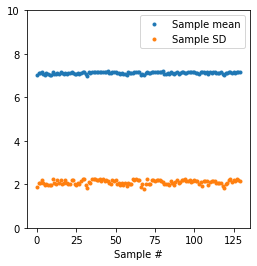

In [201]:
## Checking for normalization of expression values across samples:

sample_wise_mean = X.mean(axis=1)
sample_wise_sd = X.std(axis=1)

fig, ax = plt.subplots(figsize=(4, 4))
plt.plot(sample_wise_mean,'.',label='Sample mean')
plt.plot(sample_wise_sd,'.',label='Sample SD')
plt.ylim([0,10])
plt.xlabel('Sample #')
plt.legend(loc='best')

---

**Feature selection**

As num_features (probes) >> num_samples, some feature selection/regularization is needed to visualize the data distribution and avoid model overfitting. To start with, only the probes with highest across-sample variance of expression values (top n_probes) are retained for subsequent analysis:

In [105]:
## Selecting probes with highest variance across samples (top 500 here):
probe_wise_sd = X.std(axis=0)

n_probes = 500 
max_var_probes = [p for p,v in sorted(zip(X.columns,probe_wise_sd), key = lambda s: s[1], reverse=True)][:n_probes]
X_top = X[max_var_probes]

X_top.head()

,AFFX-HUMRGE/M10098_5_at,224588_at,242128_at,206018_at,221805_at,203001_s_at,240065_at,205000_at,206140_at,209395_at,224590_at,AFFX-HUMRGE/M10098_M_at,1568612_at,221728_x_at,209396_s_at,203000_at,205626_s_at,229012_at,206502_s_at,210033_s_at,214218_s_at,231666_at,228170_at,204712_at,236538_at,231077_at,210016_at,210809_s_at,206135_at,231731_at,206915_at,227671_at,206552_s_at,201909_at,AFFX-M27830_5_at,242344_at,205625_s_at,206826_at,205358_at,236085_at,...,232054_at,206306_at,236734_at,238021_s_at,1556329_a_at,202363_at,205651_x_at,205590_at,1569469_a_at,224997_x_at,203295_s_at,235753_at,225911_at,214217_at,223381_at,218585_s_at,1554784_at,211203_s_at,1559283_a_at,213844_at,239183_at,241382_at,206858_s_at,242881_x_at,207014_at,228598_at,228462_at,1557256_a_at,213194_at,205110_s_at,212909_at,1556444_a_at,206084_at,1556095_at,207850_at,214432_at,202037_s_at,244403_at,225645_at,204471_at
0,4.769155,5.387776,4.173756,5.223720,3.468729,6.176408,11.033385,9.136110,4.897033,4.679266,4.091570,4.687528,4.611667,7.150693,6.427436,6.601549,11.095619,12.775405,5.621846,12.035224,4.403013,10.644719,6.451659,5.944191,4.290390,12.150120,4.785396,5.989578,5.115718,4.318966,4.486196,6.373182,3.859794,11.527108,6.060622,5.202238,11.436261,10.564605,5.847065,12.065463,...,4.660987,10.965691,5.556722,10.170392,7.040364,7.182850,4.792025,6.009340,3.779234,9.023150,12.454908,5.832249,5.426833,7.177722,4.409156,5.890048,10.298868,11.329449,7.746515,5.965784,6.433439,5.857215,6.880902,4.458017,8.895991,8.267328,9.571647,6.063121,7.173545,9.472898,11.615440,7.162683,4.350726,3.519282,5.891652,7.286365,6.596274,11.080307,5.650184,6.004935
1,5.011087,12.201147,3.603069,10.345439,3.906425,8.043318,9.531044,4.410002,11.835499,6.003954,10.072409,5.125493,3.919323,10.167258,5.861033,8.442368,10.985740,9.584759,8.566359,10.802934,9.526426,4.858352,4.439667,12.039034,8.987981,10.199452,4.902029,5.614410,6.787502,4.490734,6.598442,10.866672,3.468076,7.024883,7.974346,4.315842,11.511109,10.822987,10.313491,8.097641,...,5.590738,5.810115,5.300295,7.843915,6.915932,9.721343,5.167524,9.158493,3.467608,7.536962,7.954898,4.602575,10.299938,6.541451,7.139728,8.246372,5.610903,6.674543,4.698247,6.180622,6.182677,10.990024,9.904665,4.984639,8.178026,7.631248,9.061860,9.677339,10.566962,11.346226,8.339815,7.570378,4.313228,3.598480,7.608893,5.985776,6.873919,10.123711,6.385532,8.858530
2,4.549771,5.908902,3.672538,4.735788,4.159132,6.977734,10.456710,11.217399,4.695414,13.356481,3.518604,4.578991,3.903473,5.465632,13.157542,7.244155,9.493862,10.411845,5.382950,11.047207,4.048468,9.879200,11.086066,11.888002,7.836434,10.053591,4.701786,6.765261,4.522126,4.640889,5.570471,5.928881,3.617698,12.365482,7.070830,5.095745,9.798540,11.860087,9.159438,8.268891,...,7.319111,10.000102,5.851076,9.479222,7.603950,10.700807,6.727962,6.122501,3.420132,10.109266,12.034910,4.728801,9.295492,7.107251,6.676462,7.426621,11.136350,11.496217,4.784340,8.906795,7.949111,5.645309,6.448846,4.667823,6.091603,9.938140,9.479321,4.840011,8.922723,8.428403,7.833051,7.002719,4.349924,3.658240,10.701909,6.157049,7.603360,11.013605,6.861646,11.440685
3,12.747103,12.442323,3.850587,11.892582,8.514866,9.552097,10.652081,4.456123,8.507333,8.946534,9.545054,11.065442,8.223931,12.010278,8.727838,10.143561,5.199563,13.141350,5.177328,12.331341,10.109926,3.753240,8.536778,7.277294,7.711100,12.340554,7.854968,5.940180,4.452334,4.225679,5.136555,11.302756,10.333572,7.103604,12.800238,7.077832,4.907449,8.497988,7.888028,9.134736,...,5.850894,6.456609,5.447271,8.366228,8.490645,9.213243,7.569192,7.263380,3.194060,6.719825,8.633719,5.204247,7.213988,6.698754,8.720583,9.128083,5.977038,5.773790,4.113546,5.346421,4.272169,7.713141,5.792000,4.254669,5.933448,12.082957,5.429010,6.290038,8.713314,9.234461,13.207041,6.153864,6.471266,3.847978,6.387707,6.099015,6.038060,11.551727,5.629890,10.558049
4,5.258776,12.541323,11.178197,4.640889,3.906560,7.255989,8.037306,5.142808,4.575649,13.165555,9.157431,5.393915,3.816280,11.

Visualization with 2D t-SNE:

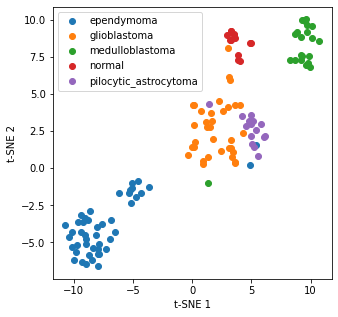

In [106]:
X_tsne = TSNE(n_components=2,random_state=42).fit_transform(X_top)

cdict = dict(zip(classes,range(1,1+len(classes))))

fig, ax = plt.subplots(figsize=(5, 5))

for cls in classes: plt.scatter(X_tsne[y==cls,0],X_tsne[y==cls,1], label=cls)

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(loc='best')

Visualizing the directions of maximum variance in the data with PCA:

In [107]:
## Standardizing the data matrix (zero mean, unit SD per feature/column)
X_scaled = StandardScaler().fit_transform(X_top)

pca = PCA(n_components=10).fit(X_scaled)

X_pca = pca.transform(X_scaled)

Text(0, 0.5, 'Proportion of variance explained')

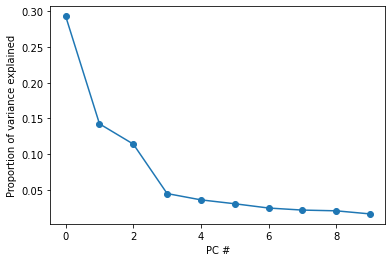

In [109]:
plt.plot(pca.explained_variance_ratio_,'o-')
plt.xlabel('PC #')
plt.ylabel('Proportion of variance explained')

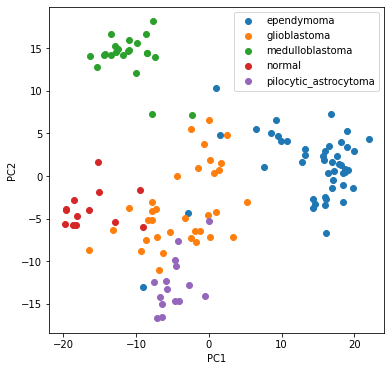

In [110]:
cdict = dict(zip(classes,range(1,1+len(classes))))

fig, ax = plt.subplots(figsize=(6, 6))

for cls in classes: plt.scatter(X_pca[y==cls,0],X_pca[y==cls,1], label=cls)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='best')

The different classes separate out quite clearly in 2D PC space for this dataset, suggesting that a prediction model using top few PCs should perform well.

**Potential caveats:** In addition to the relatively small sample size of this dataset, data leakage due to prior normalization of samples is possible. To avoid this problem in practice, raw expression data may be normalized in a way that does not leak information between train/test samples (e.g. by normalizing every sample relative to a common reference sample). [For illustration, however, we use the normalized values provided as-is.]



---


**Train-test split:**

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42,stratify=y)

print('Train #:',len(y_train))
for c in classes: print(c,len(y_train[y_train == c]))

print('Test #:',len(y_test))
for c in classes: print(c,len(y_test[y_test == c]))

Train #: 104
ependymoma 37
glioblastoma 27
medulloblastoma 18
normal 10
pilocytic_astrocytoma 12
Test #: 26
ependymoma 9
glioblastoma 7
medulloblastoma 4
normal 3
pilocytic_astrocytoma 3




---


**k-NN (nearest neighbors) classifier in the n_probes-dim space**

In [125]:
## Values are scaled by max abs value per fature/column; scaling is applied to the training data, 
## and the same scaler will be used on the test data before predictions, to avoid data leakage)
scaler = MaxAbsScaler().fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)

knnc = KNeighborsClassifier(n_neighbors=5,metric='euclidean')
knnc.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

k-NN performance on held-out test samples


In [126]:
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)
y_pred = knnc.predict(X_test_scaled)

acc = knnc.score(X_test_scaled,y_test)
f1_perclass = f1_score(y_test,y_pred,average=None,labels=y_train.unique())
f1_avg = f1_score(y_test,y_pred,average='weighted')

print('Clf accuracy:',acc, '\nMean F1-score:',f1_avg)
for c,f1 in sorted(zip(y_train.unique(),f1_perclass),key=lambda f: f[0]): print(c,f1)

Clf accuracy: 0.9230769230769231 
Mean F1-score: 0.9230769230769231
ependymoma 0.8888888888888888
glioblastoma 1.0
medulloblastoma 0.8571428571428571
normal 1.0
pilocytic_astrocytoma 0.8571428571428571


**k-NN predictor in reduced (PC) space**

In [191]:
## Standardizing the training data matrix (zero mean, unit SD per feature/column)
stdscaler = StandardScaler().fit(X_train)

X_train_scaled = stdscaler.transform(X_train)

## Projection on top two PC axes:
pca = PCA(n_components=2).fit(X_train_scaled)
X_train_pc = pca.transform(X_train_scaled)

## kNN classifier fit on training set examples with euclidean metric in 2D PC space 
knnc = KNeighborsClassifier(n_neighbors=5,weights='uniform',metric='euclidean')
knnc.fit(X_train_pc, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Testing classifier on held-out examples

In [192]:
## Projecting test cases on training set PC axes:

X_test_scaled = stdscaler.transform(X_test)
X_test_pc = pca.transform(X_test_scaled)

## Predicting classes:

y_pred = knnc.predict(X_test_pc)

acc = knnc.score(X_test_pc,y_test)
f1_perclass = f1_score(y_test,y_pred,average=None,labels=y_train.unique())
f1_avg = f1_score(y_test,y_pred,average='weighted')

print('Clf accuracy:',acc, '\nMean F1-score:',f1_avg)
for c,f1 in sorted(zip(y_train.unique(),f1_perclass),key=lambda f: f[0]): print(c,f1)

Clf accuracy: 0.9230769230769231 
Mean F1-score: 0.9230769230769231
ependymoma 0.8888888888888888
glioblastoma 1.0
medulloblastoma 0.8571428571428571
normal 1.0
pilocytic_astrocytoma 0.8571428571428571


Visualizing decision boundaries in 2D space:

Text(0.5, 1.0, 'Decision boundaries for k-NN classifier')

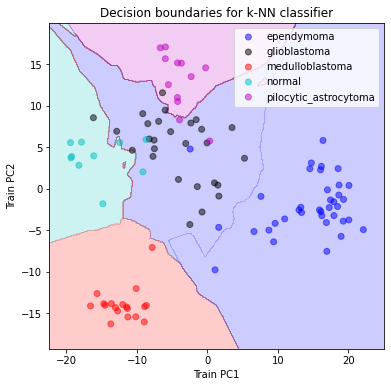

In [200]:
class2num = dict(zip(classes,range(1,1+len(classes))))
cmap_classes = ListedColormap(['b','k','r','c','m'])

h=0.1
margin=3

x_min, x_max = X_train_pc[:, 0].min() - margin, X_train_pc[:, 0].max() + margin
y_min, y_max = X_train_pc[:, 1].min() - margin, X_train_pc[:, 1].max() + margin
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
Z = np.array([class2num[cls] for cls in knnc.predict(np.c_[xx.ravel(), yy.ravel()])])

Z = Z.reshape(xx.shape)

plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, Z, cmap=cmap_classes, alpha=0.2)

## Overlaying training data (same colormap):

cdict = dict(zip(classes,['b','k','r','c','m']))

for cls in classes: plt.scatter(X_train_pc[y_train==cls,0],X_train_pc[y_train==cls,1], c = [cdict[cls] for i in range(len(y_train[y_train==cls]))], label=cls,alpha=0.5)
plt.xlabel('Train PC1')
plt.ylabel('Train PC2')
plt.legend(loc='best')

plt.title('Decision boundaries for k-NN classifier')